# Train and evaluate a PC

In [1]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cpu")  # The device to use, e.g., "cpu", "cuda", "cuda:1"

Set the random seeds.

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if 'cuda' in device.type:
    torch.cuda.manual_seed(42)

## Load MNIST Dataset

Load the training and test splits of MNIST, and preprocess them by flattening the tensor images.

In [4]:
from torchvision import transforms, datasets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (255 * x.view(-1)).long())
])
data_train = datasets.MNIST('datasets', train=True, download=True, transform=transform)
data_test = datasets.MNIST('datasets', train=False, download=True, transform=transform)
num_variables = data_train[0][0].shape[0]
print(f"Number of variables: {num_variables}")

Number of variables: 784


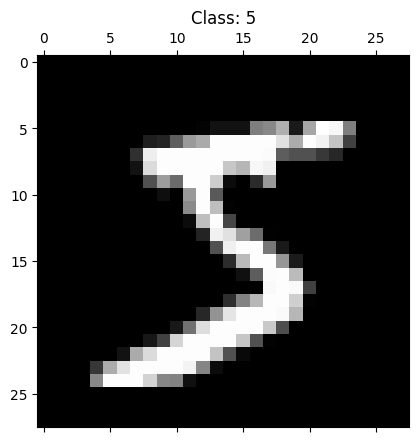

In [5]:
plt.matshow(data_train[0][0].reshape(28, 28), cmap='gray')
plt.title(f"Class: {data_train[0][1]}")
plt.show()

## Instantiating the region graph

Initialize a _Random Binary Tree_ region graph with depth 3 and number of repetitions 1.
This region graph has been introduced in [Random Sum-Product Networks: A Simple and Effective Approach to Probabilistic Deep Learning](https://proceedings.mlr.press/v115/peharz20a.html).

In [6]:
from cirkit.region_graph.random_binary_tree import RandomBinaryTree
region_graph = RandomBinaryTree(num_variables, depth=3, num_repetitions=1)

Others available region graphs are [_Poon Domingos_](https://arxiv.org/abs/1202.3732) and _QuadTree_, whose imports are showed below.

In [7]:
from cirkit.region_graph.poon_domingos import PoonDomingos
from cirkit.region_graph.quad_tree import QuadTree

## Choosing the layers

Now we have to choose both the input and inner layers of our circuit. As input layer we select the _CategoricalLayer_ with 256 categories (the number of pixel values). For the inner layer instead, we choose the _uncollapsed CP_ layer with rank 1.

In [8]:
from cirkit.layers.input.exp_family import CategoricalLayer
from cirkit.layers.sum_product import CPLayer
efamily_cls = CategoricalLayer
efamily_kwargs = {'num_categories': 256}
layer_cls = CPLayer
layer_kwargs = {'rank': 1, 'prod_exp': True}

## Building the tensorized PC

We can now build our tensorized PC by specifying the region graph and layers we chose previously. In addition, we can scale the architecture by increasing the number of input and inner units. We can also have circuits with multiple output units by choosing _num_classes > 1_. However, in this notebook we only estimate the distribution of the images and marginalize out the class variable.

To ensure weights are non-negative we reparametrize them via exponentiation. Several reparametrization functions are available.

In [9]:
from cirkit.utils.reparams import reparam_exp
from cirkit.models.tensorized_circuit import TensorizedPC
pc = TensorizedPC.from_region_graph(
    region_graph,
    num_inner_units=2,
    num_input_units=2,
    efamily_cls=efamily_cls,
    efamily_kwargs=efamily_kwargs,
    layer_cls=layer_cls,
    layer_kwargs=layer_kwargs,
    num_classes=1,
    reparam=reparam_exp
)
pc.to(device)
print(pc)

TensorizedPC(
  (input_layer): CategoricalLayer()
  (scope_layer): ScopeLayer()
  (inner_layers): ModuleList(
    (0-2): 3 x CPLayer()
  )
)


## Training and testing

We are now ready to learn the parameters. First, we wrap our data into PyTorch data loaders by specifying the batch size. Then, we initialize any PyTorch optimizer, e.g. Adam in this case.

In [10]:
from torch import optim
from torch.utils.data import DataLoader
train_dataloader = DataLoader(data_train, shuffle=True, batch_size=256)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256)
optimizer = optim.Adam(pc.parameters(), lr=0.01)

Since the constructed PC is not necessarily normalized, we construct the integral circuit that will compute the partition function. Note that parameters are shared and therefore there is no additional memory required.

In [11]:
from cirkit.models.functional import integrate
pc_pf = integrate(pc)

Finally, we optimize the parameters for 5 epochs by minimizing the negative log-likelohood.

In [ ]:
num_epochs = 5
for epoch_idx in range(num_epochs):
    running_loss = 0.0
    for batch, _ in train_dataloader:
        log_score = pc.forward(batch)
        log_pf = pc_pf()          # Compute the partition function
        lls = log_score - log_pf  # Compute the log-likelihood
        loss = -torch.mean(lls)   # The loss is the negative average log-likelihood
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss * len(batch)
        # Clamp the parameters to ensure they are in the intended domain
        # This is needed if we do not used any reparametrization to ensure parameters non-negativity
        #for layer in model.inner_layers:
        #    layer.clamp_params()
    print(f"Epoch {epoch_idx}: Average NLL: {running_loss / len(data_train):.3f}")

Epoch 0: Average NLL: 3198.241
Epoch 1: Average NLL: 1334.357
Epoch 2: Average NLL: 986.520
Epoch 3: Average NLL: 944.555


We then evaluate our model on test data by computing the average log-likelihood and bits per dimension.

In [ ]:
with torch.no_grad():
    pc.eval()
    log_pf = pc_pf()  # Compute the partition function once for testing
    test_lls = 0.0
    for batch, _ in test_dataloader:
        log_score = pc.forward(batch)
        lls = log_score - log_pf
        test_lls += lls.sum().item()
    average_ll = test_lls / len(data_test)
    bpd = -average_ll / (num_variables * np.log(2.0))
    print(f"Average test LL: {average_ll:.3f}")
    print(f"Bits per dimension: {bpd}")